# Import Packages

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
# sns.set_theme(style="white")
# sns.color_palette("Set2")
import pymc as pm
import arviz as az
import xarray as xr

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

In [12]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

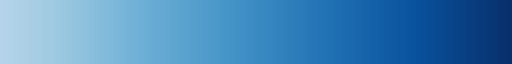

In [13]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [14]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

# Import Data

In [15]:
df = pd.read_csv('data/hourly_data.csv')
df.head()

,DateTime,Charging,Not_charging,Month,Day,Time,N_active,PIV,Large_battery
0,2017-07-04 00:00:00,0,0,7,1,0,0,BEV,0
1,2017-07-04 01:00:00,0,0,7,1,1,0,BEV,0
2,2017-07-04 02:00:00,0,0,7,1,2,0,BEV,0
3,2017-07-04 03:00:00,0,0,7,1,3,0,BEV,0
4,2017-07-04 04:00:00,0,0,7,1,4,0,BEV,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39024 entries, 0 to 39023
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       39024 non-null  object
 1   Charging       39024 non-null  int64 
 2   Not_charging   39024 non-null  int64 
 3   Month          39024 non-null  int64 
 4   Day            39024 non-null  int64 
 5   Time           39024 non-null  int64 
 6   N_active       39024 non-null  int64 
 7   PIV            39024 non-null  object
 8   Large_battery  39024 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 2.7+ MB


### Add Is_Weekend

In [17]:
df['Is_Weekend'] = 0
df.loc[df.Day >= 5, 'Is_Weekend'] = 1

### Get Month Names

In [18]:
import calendar
df['Month_Name'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

### Filter for BEVs only

In [19]:
bev_df = df[df.PIV == 'BEV']
bev_df.head()

,DateTime,Charging,Not_charging,Month,Day,Time,N_active,PIV,Large_battery,Is_Weekend,Month_Name
0,2017-07-04 00:00:00,0,0,7,1,0,0,BEV,0,0,Jul
1,2017-07-04 01:00:00,0,0,7,1,1,0,BEV,0,0,Jul
2,2017-07-04 02:00:00,0,0,7,1,2,0,BEV,0,0,Jul
3,2017-07-04 03:00:00,0,0,7,1,3,0,BEV,0,0,Jul
4,2017-07-04 04:00:00,0,0,7,1,4,0,BEV,0,0,Jul


# Multi-level Model (Variable Intercept and Slope with Non-centered Parameterisation)

In [20]:
coords = {'month':[calendar.month_abbr[x] for x in range(1, 13)],
          'hour': [x for x in range(0, 24)],
          'weekend': ['Weekday', 'Weekend'],
          'battery':['Small', 'Large']
}

In [31]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered_model:

    is_weekend_idx = pm.MutableData("is_weekend_idx", bev_df.Is_Weekend, dims="obs_id")
    month_idx = pm.MutableData("month_idx", bev_df.Month - 1, dims="obs_id")
    hour_idx = pm.MutableData("hour_idx", bev_df.Time - 1, dims="obs_id")
    battery_idx = pm.MutableData("battery_idx", bev_df.Large_battery, dims="obs_id")
    
    n_active = pm.MutableData("n_active", bev_df.N_active, dims="obs_id")

    # Hyper Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Non-centered Random Intercepts
    # Centered: a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims='month')
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims=('month', 'hour'))
    a = pm.Deterministic("a", mu_a + z_a * sigma_a, dims=('month', 'hour'))

    # Non-centered Random Slopes
    b = pm.Normal('z_b', mu=0, sigma=1, dims=('month', 'hour'))

    # Non-centered Random Slopes
    c = pm.Normal('z_c', mu=0, sigma=1, dims=('month', 'hour'))

    p = pm.Deterministic('p', pm.math.invlogit(a[month_idx, hour_idx] + b[month_idx, hour_idx] * is_weekend_idx + c[month_idx, hour_idx] * battery_idx), dims="obs_id")

    n_charging = pm.Binomial("n_charging", p=p, n=n_active, observed=bev_df.Charging.values, dims="obs_id")

    agg_demand = pm.Deterministic('agg_demand', n_charging * 7, dims='obs_id')

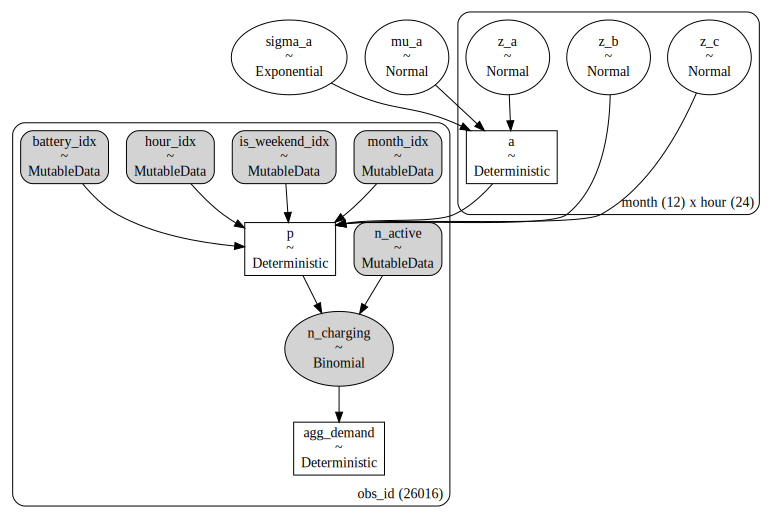

In [32]:
pm.model_to_graphviz(varying_intercept_slope_noncentered_model)

In [33]:
with varying_intercept_slope_noncentered_model:
    noncentered_trace = pm.sample(tune=2000, target_accept=0.95, random_seed=RANDOM_SEED, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Not enough samples to build a trace.

## Simple Model

In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered_model:

    is_weekend_idx = pm.MutableData("is_weekend_idx", bev_df.Is_Weekend, dims="obs_id")
    month_idx = pm.MutableData("month_idx", bev_df.Month - 1, dims="obs_id")
    hour_idx = pm.MutableData("hour_idx", bev_df.Time - 1, dims="obs_id")
    battery_idx = pm.MutableData("battery_idx", bev_df.Large_battery, dims="obs_id")
    
    n_active = pm.MutableData("n_active", bev_df.N_active, dims="obs_id")

    # Hyper Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Non-centered Random Intercepts
    # Centered: a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims='month')
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims=('month', 'hour'))
    a = pm.Deterministic("a", mu_a + z_a * sigma_a, dims=('month', 'hour'))

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=5)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Non-centered Random Slopes
    z_b = pm.Normal('z_b', mu=0, sigma=1, dims=('month', 'hour'))
    b = pm.Normal('b', mu_b + z_b * sigma_b, dims=('month', 'hour'))

    mu_c = pm.Normal("mu_c", mu=0.0, sigma=5)
    sigma_c = pm.Exponential("sigma_c", 1)

    # Non-centered Random Slopes
    z_c = pm.Normal('z_c', mu=0, sigma=1, dims=('battery', 'hour'))
    c = pm.Normal('c', mu_c + z_c * sigma_c, dims=('battery', 'hour'))

    p = pm.Deterministic('p', pm.math.invlogit(a[month_idx, hour_idx] + b[month_idx, hour_idx] * is_weekend_idx + c[battery_idx, hour_idx]), dims="obs_id")

    n_charging = pm.Binomial("n_charging", p=p, n=n_active, observed=bev_df.Charging.values, dims="obs_id")

    agg_demand = pm.Deterministic('agg_demand', n_charging * 7, dims='obs_id')

# Lets build some probabilistic profiles

In [27]:
is_weekend = 0
month = 2
n_bev = 100

In [106]:
def generate_24h_predictions(is_weekend, month, n_bev, noncentered_trace):
    predictions = np.zeros([24, 4000])
    for hour in range(24):
        with varying_intercept_slope_noncentered_model:
            pm.set_data(
                {"is_weekend_idx": [is_weekend],
                "month_idx": [month-1],
                "hour_idx": [hour],
                "n_active": [n_bev]
                }
            )
            trace = pm.sample_posterior_predictive(
                noncentered_trace,
                var_names=['n_charging','agg_demand'],
                return_inferencedata=True,
                predictions=True,
                random_seed=RANDOM_SEED,
            )
        combined_trace = trace.stack(combined=('chain', 'draw'))
        predictions[hour] = combined_trace.predictions.agg_demand[0].to_numpy()
    return predictions

In [45]:
def calculate_percentile_profile(percentile, predictions):
    profile = np.zeros(24)
    for i in range(24):
        profile[i] = np.percentile(predictions[i], percentile)
    return profile

In [31]:
months = ['January',
          'February',
          'March',
          'April',
          'May',
          'June',
          'July',
          'August',
          'September',
          'October',
          'November',
          'December'
          ]
weekdays = ['Weekday', 'Weekend']

In [108]:
def plot_daily_profile(is_weekend, month, n_bev, noncentered_trace):
    
    predictions = generate_24h_predictions(is_weekend, month, n_bev, noncentered_trace)
    
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(x=range(24), 
                    y1=calculate_percentile_profile(25, predictions), 
                    y2=calculate_percentile_profile(75, predictions), 
                    color=colors[19],
                    alpha=0.4,
                    label='Interquartile Range')

    ax.fill_between(x=range(24), 
                    y1=calculate_percentile_profile(5, predictions), 
                    y2=calculate_percentile_profile(95, predictions), 
                    color=colors[19],
                    alpha=0.2,
                    label='5th to 95th Percentile')

    ax.plot(calculate_percentile_profile(50, predictions), 
            linewidth=2, 
            c='green', 
            label='Median')

    ax.plot(calculate_percentile_profile(0, predictions), 
            linewidth=1, 
            c=colors[1], 
            label='Minimum',
            linestyle='--')

    ax.plot(calculate_percentile_profile(100, predictions), 
            linewidth=1, 
            c=colors[19], 
            label='Maximum',
            linestyle='--')

    ax.set_title('Total Charging Demand for {} BEVs (7kW Power) in {} on {}s'.format(n_bev, months[month-1], weekdays[is_weekend]))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), 
            reversed(labels), 
            #   loc='upper left',
            bbox_to_anchor=(1, 0.9), 
            title='Percentile', 
            title_fontsize=16, 
            fontsize=10)

    ax.set_xticks(range(0,24))
    ax.set_ylabel('Demand (kW)', fontsize=16)
    ax.set_xlabel('Time (Hours)', fontsize=16)
#     ax.set_ylim(0, n_bev*7)
    ax.set_xlim(0, 23)
    plt.show()

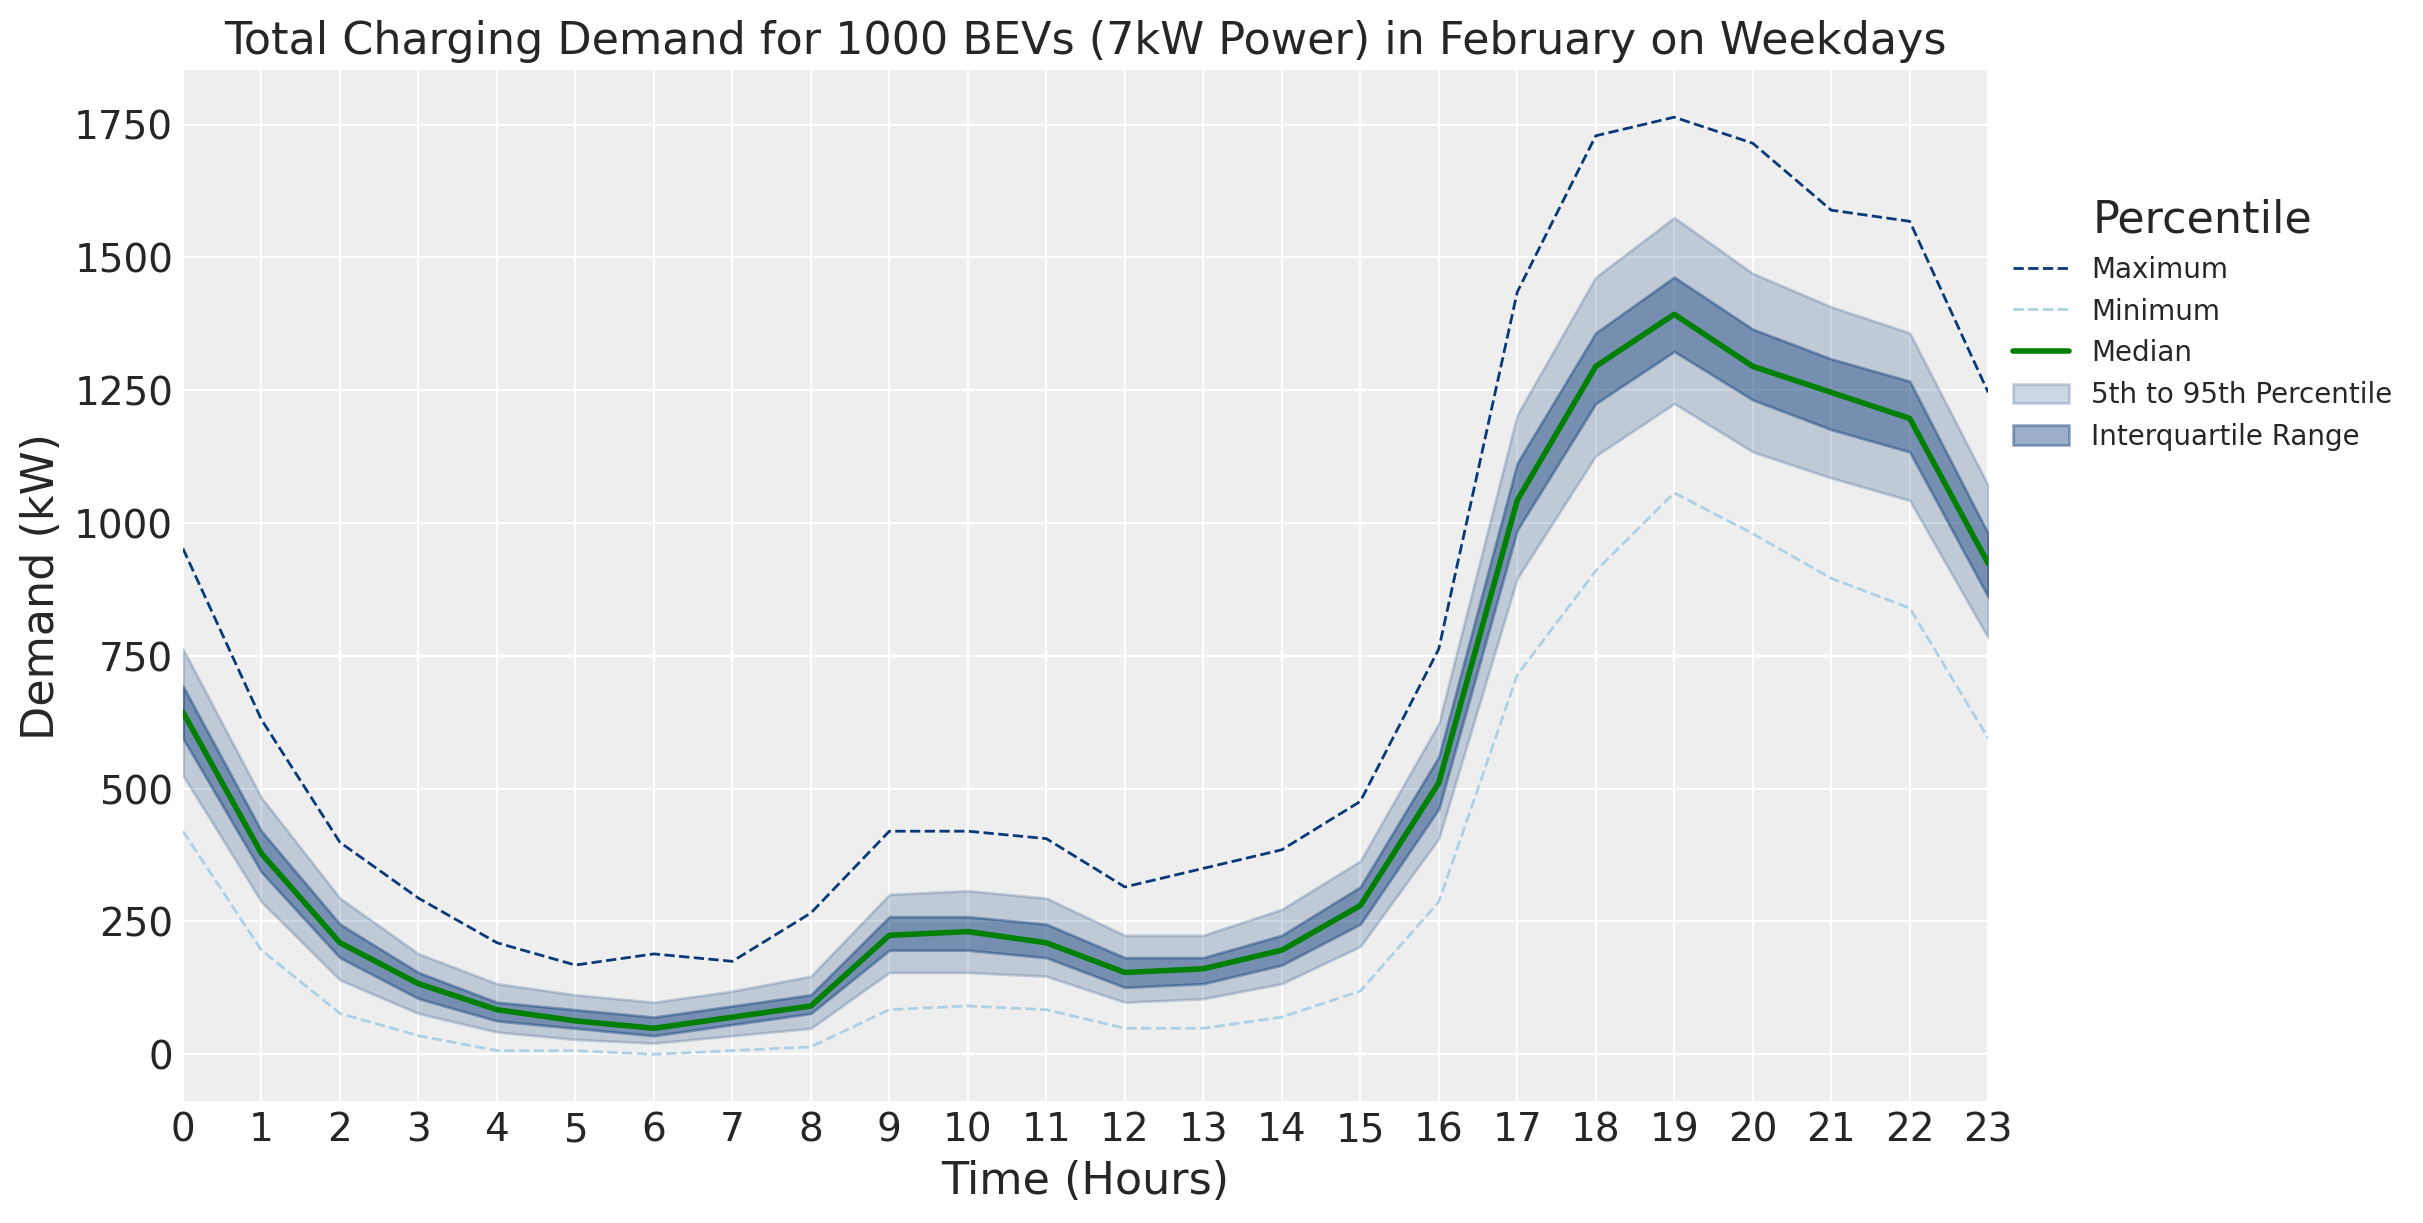

In [111]:
is_weekend = 0
month = 2
n_bev = 1000
plot_daily_profile(is_weekend, month, n_bev, noncentered_trace)

In [88]:
predictions = generate_24h_predictions(is_weekend, month, n_bev)
predictions

array([[ 63.,  98.,  63., ...,  35.,  49.,  77.],
       [ 35.,  63.,  42., ...,  14.,  28.,  49.],
       [ 21.,  42.,  21., ...,   7.,  14.,  28.],
       ...,
       [119., 175., 126., ...,  77., 105., 147.],
       [112., 175., 119., ...,  84.,  91., 147.],
       [ 91., 126.,  98., ...,  49.,  84., 119.]])

# Trying a different approach to modelling (Proper partial pooling?)

In [89]:
with pm.Model(coords=coords) as model_1:

    is_weekend_idx = pm.MutableData("is_weekend_idx", bev_df.Is_Weekend, dims="obs_id")
    month_idx = pm.MutableData("month_idx", bev_df.Month - 1, dims="obs_id")
    hour_idx = pm.MutableData("hour_idx", bev_df.Time - 1, dims="obs_id")
    n_active = pm.MutableData("n_active", bev_df.N_active, dims="obs_id")

    # Hyper Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=5)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=5)
    sigma_b = pm.Exponential("sigma_b", 1)

    mu_c = pm.Normal("mu_c", mu=0.0, sigma=5)
    sigma_c = pm.Exponential("sigma_c", 1)

    mu_d = pm.Normal("mu_d", mu=0.0, sigma=5)
    sigma_d = pm.Exponential("sigma_d", 1)

    # Non-centered Random Intercepts
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims='month')
    a = pm.Deterministic("a", mu_a + z_a * sigma_a, dims='month')

    z_b = pm.Normal('z_b', mu=0, sigma=1, dims='hour')
    b = pm.Normal('b', mu_b + z_b * sigma_b, dims='hour')
    
    # Non-centered Random Slopes
    z_c = pm.Normal('z_c', mu=0, sigma=1, dims='month')
    c = pm.Normal('c', mu_c + z_c * sigma_c, dims='month')

    z_d = pm.Normal('z_d', mu=0, sigma=1, dims='hour')
    d = pm.Normal('d', mu_d + z_d * sigma_d, dims='hour')

    p = pm.Deterministic('p', pm.math.invlogit((a[month_idx] + b[hour_idx]) + ((c[month_idx] + d[hour_idx]) * is_weekend_idx)), dims="obs_id")

    n_charging = pm.Binomial("n_charging", p=p, n=n_active, observed=bev_df.Charging.values, dims="obs_id")

    agg_demand = pm.Deterministic('agg_demand', n_charging * 7, dims='obs_id')

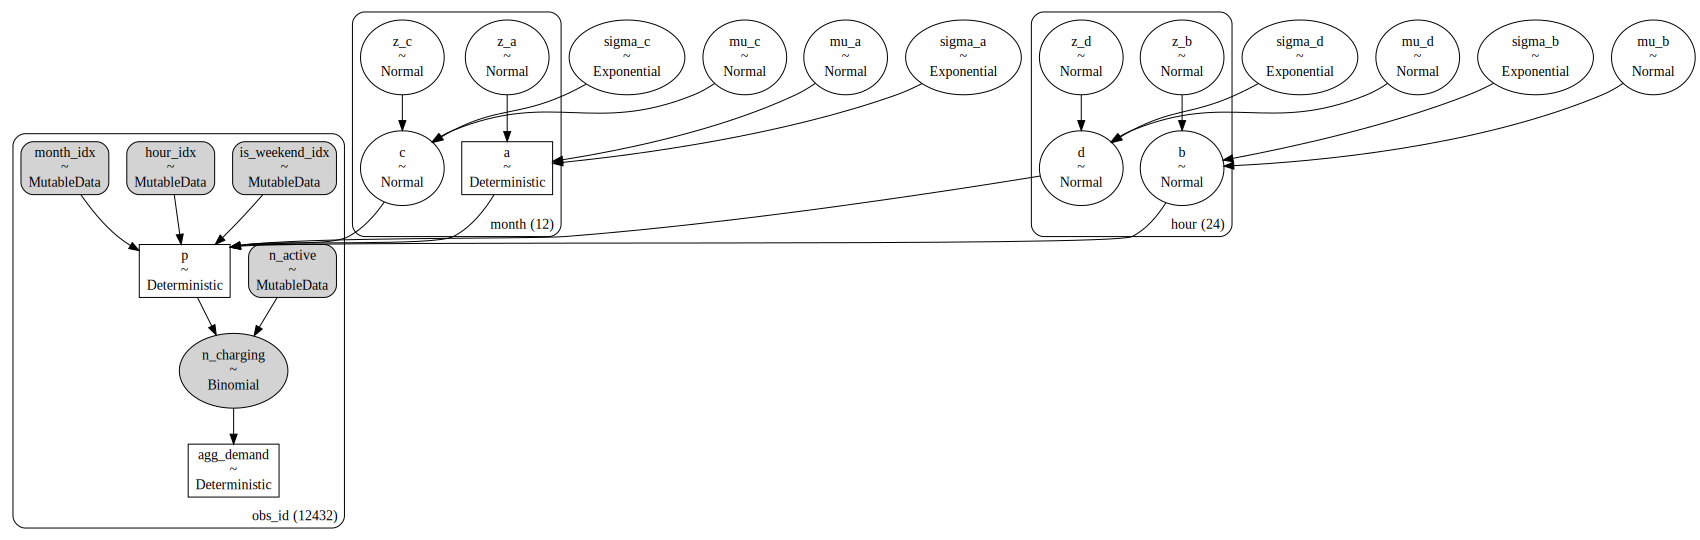

In [90]:
pm.model_to_graphviz(model_1)

In [91]:
with model_1:
    noncentered_trace_2 = pm.sample(tune=2000, target_accept=0.95, random_seed=RANDOM_SEED, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, mu_c, sigma_c, mu_d, sigma_d, z_a, z_b, b, z_c, c, z_d, d]


Sampling 4 chains for 2_000 tune and 582 draw iterations (8_000 + 2_328 draws total) took 2715 seconds.


In [ ]:
with pm.Model(coords=coords) as model_2:

    is_weekend_idx = pm.MutableData("is_weekend_idx", bev_df.Is_Weekend, dims="obs_id")
    month_idx = pm.MutableData("month_idx", bev_df.Month - 1, dims="obs_id")
    hour_idx = pm.MutableData("hour_idx", bev_df.Time - 1, dims="obs_id")
    n_active = pm.MutableData("n_active", bev_df.N_active, dims="obs_id")

    # Hyper Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=5)
    sigma_a = pm.Exponential("sigma_a", 1)

    sigma_b = pm.Exponential("sigma_b", 1)

    mu_c = pm.Normal("mu_c", mu=0.0, sigma=5)
    sigma_c = pm.Exponential("sigma_c", 1)

    mu_d = pm.Normal("mu_d", mu=0.0, sigma=5)
    sigma_d = pm.Exponential("sigma_d", 1)

    # Non-centered Random Intercepts
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims='month')
    a = pm.Deterministic("a", mu_a + z_a * sigma_a, dims='month')

    z_b = pm.Normal('z_b', mu=0, sigma=1, dims='hour')
    b = pm.Normal('b', z_b * sigma_b, dims='hour')
    
    # Non-centered Random Slopes
    z_c = pm.Normal('z_c', mu=0, sigma=1, dims='month')
    c = pm.Normal('c', mu_c + z_c * sigma_c, dims='month')

    z_d = pm.Normal('z_d', mu=0, sigma=1, dims='hour')
    d = pm.Normal('d', mu_d + z_d * sigma_d, dims='hour')

    p = pm.Deterministic('p', pm.math.invlogit((a[month_idx] + b[hour_idx]) + ((c[month_idx] + d[hour_idx]) * is_weekend_idx)), dims="obs_id")

    n_charging = pm.Binomial("n_charging", p=p, n=n_active, observed=bev_df.Charging.values, dims="obs_id")

    agg_demand = pm.Deterministic('agg_demand', n_charging * 7, dims='obs_id')

<Axes: ylabel='Density'>

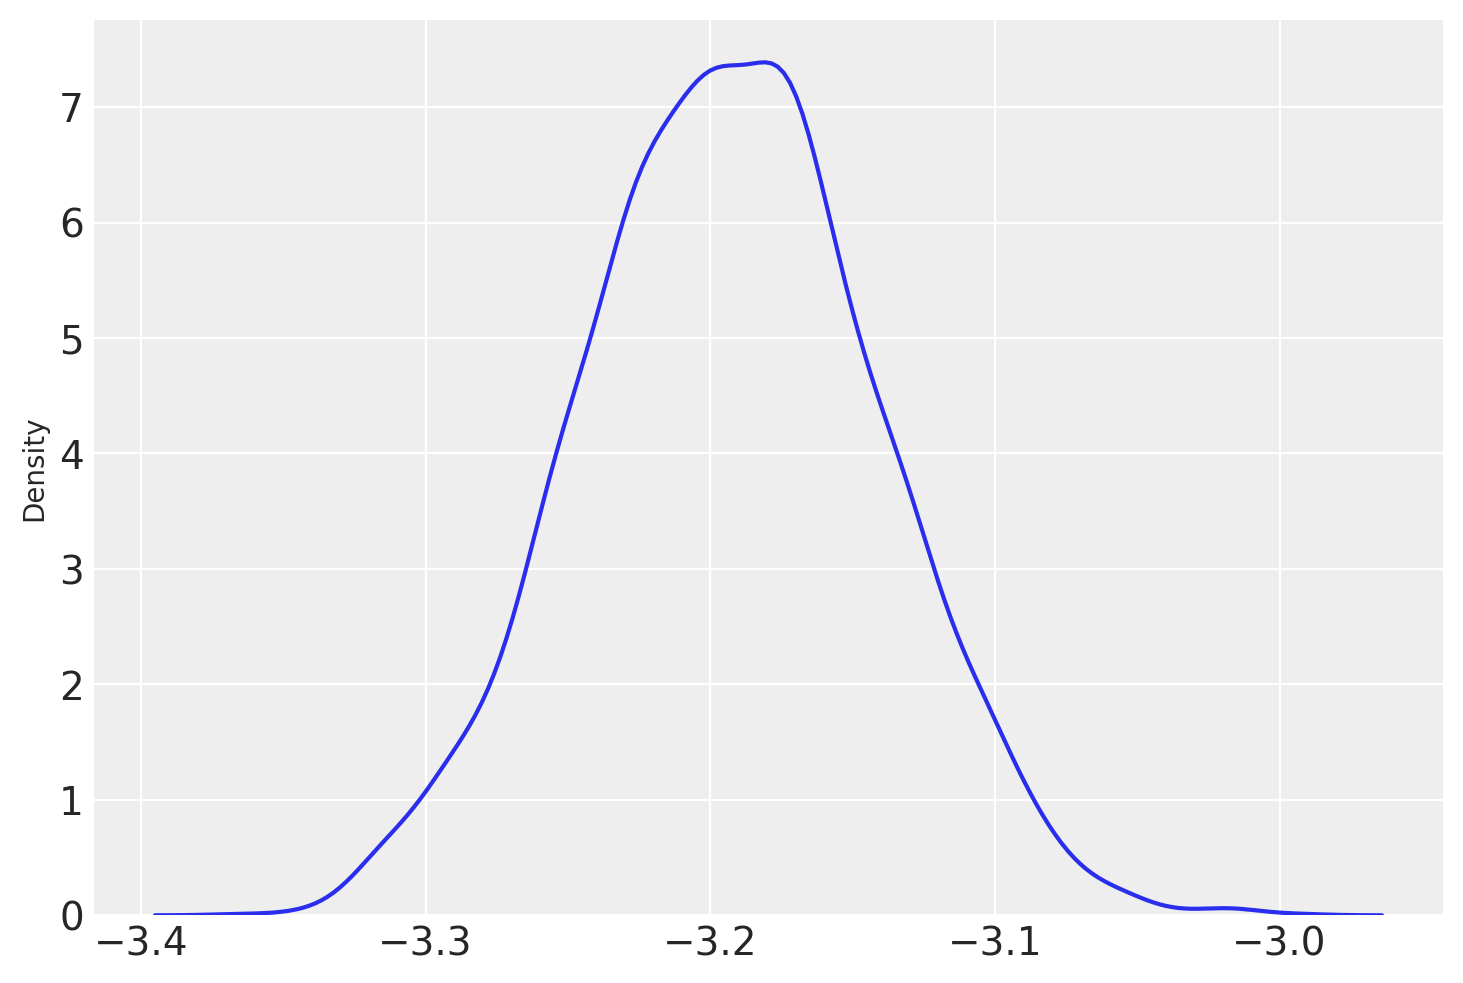

In [99]:
sns.kdeplot(noncentered_trace.stack(combined=('chain', 'draw')).posterior.mu_a)

<Axes: ylabel='Density'>

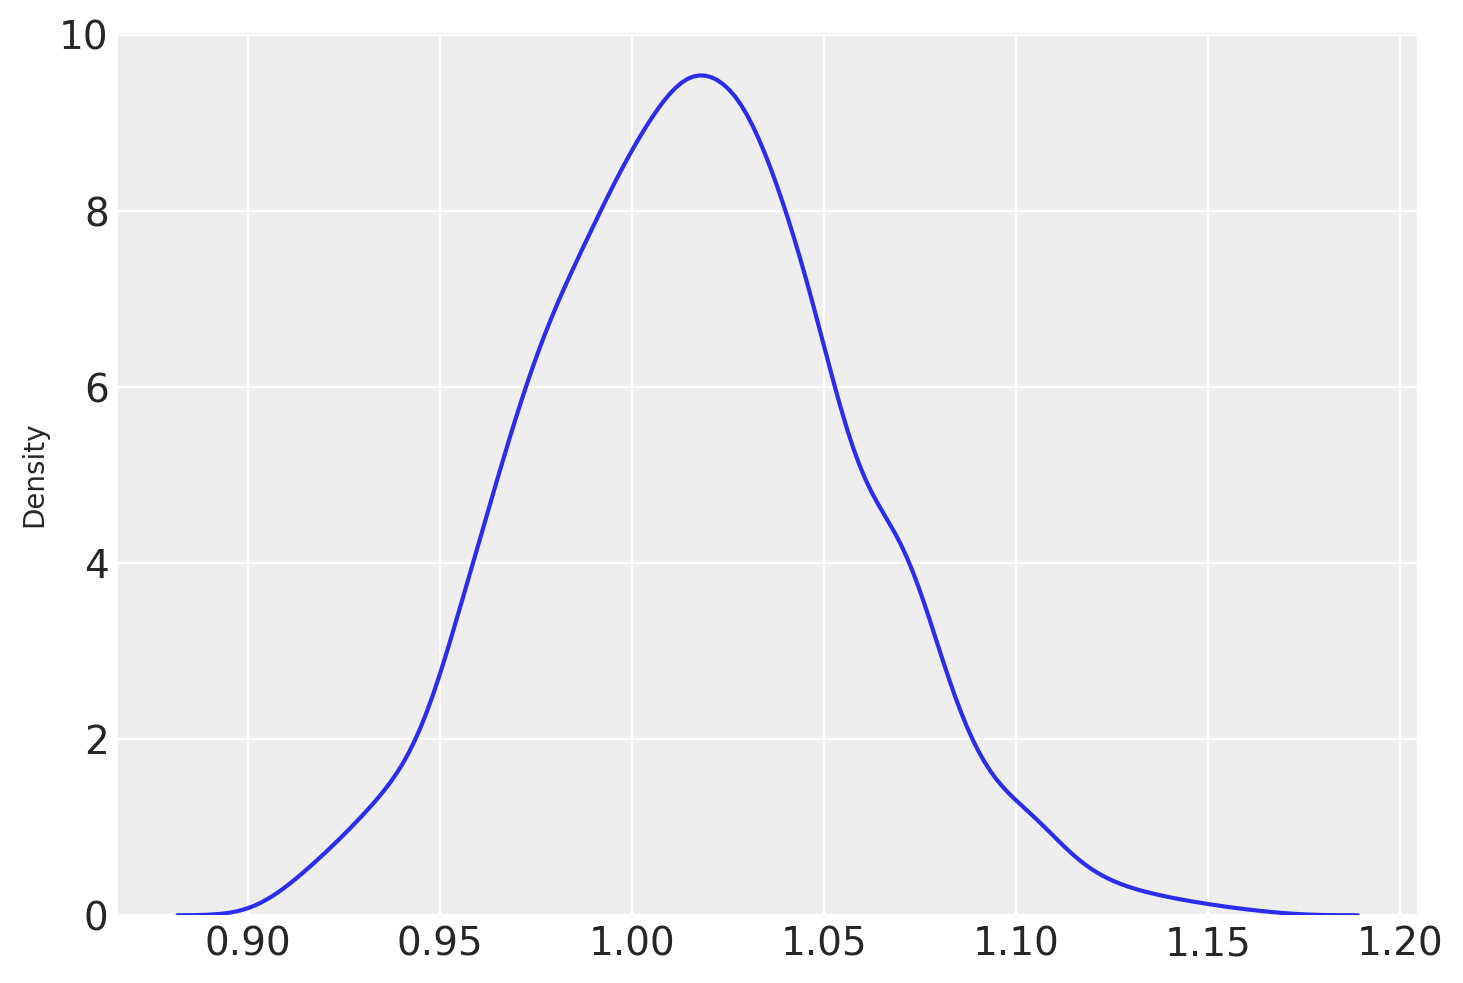

In [97]:
sns.kdeplot(noncentered_trace.stack(combined=('chain', 'draw')).posterior.sigma_a)